In [1]:
!pip install requests beautifulsoup4 lxml

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)"

In [4]:
response = requests.get(url)
print(response)

<Response [403]>


In [5]:
# Add headers to mimic a real browser since the response was 403 i.e forbidden
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/120.0.0.0 Safari/537.36"
}

response = requests.get(url, headers=headers)
print(response)

<Response [200]>


In [8]:
soup = BeautifulSoup(response.text, "lxml")
# print(soup)

In [10]:
# Get the first wikitable
table = soup.find("table", {"class": "wikitable"})
# print(table)

In [11]:
# Convert to dataframe
df = pd.read_html(str(table))[0]
print(df)

    Country/Territory  IMF[1][6]            World Bank[7]             \
    Country/Territory   Forecast       Year      Estimate       Year   
0               World  113795678       2025     111326370       2024   
1       United States   30507217       2025      29184890       2024   
2               China   19231705  [n 1]2025      18743803  [n 3]2024   
3             Germany    4744804       2025       4659929       2024   
4               India    4187017       2025       3912686       2024   
..                ...        ...        ...           ...        ...   
217          Kiribati        312       2025           308       2024   
218  Marshall Islands        297       2025           280       2024   
219             Nauru        169       2025           160       2024   
220        Montserrat          —          —             —          —   
221            Tuvalu         65       2025            62       2023   

    United Nations[8]             
             Estimate       

/tmp/ipython-input-4015434716.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


In [12]:
print("Raw columns:", df.columns)

Raw columns: MultiIndex([('Country/Territory', 'Country/Territory'),
            (        'IMF[1][6]',          'Forecast'),
            (        'IMF[1][6]',              'Year'),
            (    'World Bank[7]',          'Estimate'),
            (    'World Bank[7]',              'Year'),
            ('United Nations[8]',          'Estimate'),
            ('United Nations[8]',              'Year')],
           )


In [14]:
# Flatten MultiIndex columns into single strings
df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

print("Flattened columns:", df.columns)

Flattened columns: Index(['Country/Territory_Country/Territory', 'IMF[1][6]_Forecast',
       'IMF[1][6]_Year', 'World Bank[7]_Estimate', 'World Bank[7]_Year',
       'United Nations[8]_Estimate', 'United Nations[8]_Year'],
      dtype='object')


In [16]:
# Clean Columns, rename for simplicity

df = df.rename(columns={
    'Country/Territory_Country/Territory': 'Country',
    'IMF[1][6]_Forecast': 'IMF_Forecast',
    'IMF[1][6]_Year': 'IMF_Year',
    'World Bank[7]_Estimate': 'WorldBank_Estimate',
    'World Bank[7]_Year': 'WorldBank_Year',
    'United Nations[8]_Estimate': 'UN_Estimate',
    'United Nations[8]_Year': 'UN_Year'
})

print(df)


              Country IMF_Forecast   IMF_Year WorldBank_Estimate  \
0               World    113795678       2025          111326370   
1       United States     30507217       2025           29184890   
2               China     19231705  [n 1]2025           18743803   
3             Germany      4744804       2025            4659929   
4               India      4187017       2025            3912686   
..                ...          ...        ...                ...   
217          Kiribati          312       2025                308   
218  Marshall Islands          297       2025                280   
219             Nauru          169       2025                160   
220        Montserrat            —          —                  —   
221            Tuvalu           65       2025                 62   

    WorldBank_Year UN_Estimate    UN_Year  
0             2024   100834796       2022  
1             2024    27720700       2023  
2        [n 3]2024    17794782  [n 1]2023  
3      

Clean data

In [20]:
# Remove rows like 'World' aggregate since we want only countries
df = df[df["Country"] != "World"]
print(df)

              Country IMF_Forecast   IMF_Year WorldBank_Estimate  \
1       United States     30507217       2025           29184890   
2               China     19231705  [n 1]2025           18743803   
3             Germany      4744804       2025            4659929   
4               India      4187017       2025            3912686   
5               Japan      4186431       2025            4026211   
..                ...          ...        ...                ...   
217          Kiribati          312       2025                308   
218  Marshall Islands          297       2025                280   
219             Nauru          169       2025                160   
220        Montserrat            —          —                  —   
221            Tuvalu           65       2025                 62   

    WorldBank_Year UN_Estimate    UN_Year  
1             2024    27720700       2023  
2        [n 3]2024    17794782  [n 1]2023  
3             2024     4525704       2023  
4      

In [22]:
# Function to clean numeric columns
def clean_numeric(col):
    return (
        col.astype(str)  # ensure string
        .str.replace(r"\[.*?\]", "", regex=True)  # remove [n 1], [n 3], etc.
        .str.replace(",", "", regex=True)  # remove commas
        .str.replace("—", "", regex=True)  # replace em-dash with blank
        .replace("", np.nan)  # convert blanks to NaN
        .astype(float)  # convert to float
    )

# Apply cleaning to GDP estimate columns
for col in ["IMF_Forecast", "WorldBank_Estimate", "UN_Estimate"]:
    df[col] = clean_numeric(df[col])

print(df)

              Country  IMF_Forecast   IMF_Year  WorldBank_Estimate  \
1       United States    30507217.0       2025          29184890.0   
2               China    19231705.0  [n 1]2025          18743803.0   
3             Germany     4744804.0       2025           4659929.0   
4               India     4187017.0       2025           3912686.0   
5               Japan     4186431.0       2025           4026211.0   
..                ...           ...        ...                 ...   
217          Kiribati         312.0       2025               308.0   
218  Marshall Islands         297.0       2025               280.0   
219             Nauru         169.0       2025               160.0   
220        Montserrat           NaN          —                 NaN   
221            Tuvalu          65.0       2025                62.0   

    WorldBank_Year  UN_Estimate    UN_Year  
1             2024   27720700.0       2023  
2        [n 3]2024   17794782.0  [n 1]2023  
3             2024    45

In [23]:
# Clean years too (remove footnotes and convert to int)
for col in ["IMF_Year", "WorldBank_Year", "UN_Year"]:
    df[col] = (
        df[col].astype(str)
        .str.replace(r"\[.*?\]", "", regex=True)
        .str.replace("—", "", regex=True)
        .replace("", np.nan)
        .astype(float)
        .astype("Int64")  # keep as integer with NaN support
    )

print(df)

              Country  IMF_Forecast  IMF_Year  WorldBank_Estimate  \
1       United States    30507217.0      2025          29184890.0   
2               China    19231705.0      2025          18743803.0   
3             Germany     4744804.0      2025           4659929.0   
4               India     4187017.0      2025           3912686.0   
5               Japan     4186431.0      2025           4026211.0   
..                ...           ...       ...                 ...   
217          Kiribati         312.0      2025               308.0   
218  Marshall Islands         297.0      2025               280.0   
219             Nauru         169.0      2025               160.0   
220        Montserrat           NaN      <NA>                 NaN   
221            Tuvalu          65.0      2025                62.0   

     WorldBank_Year  UN_Estimate  UN_Year  
1              2024   27720700.0     2023  
2              2024   17794782.0     2023  
3              2024    4525704.0     20

In [24]:
# Save to device
from google.colab import files

# Save cleaned CSV
df.to_csv("GDP.csv", index=False)

# Download to your local computer
files.download("GDP.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data Analysis

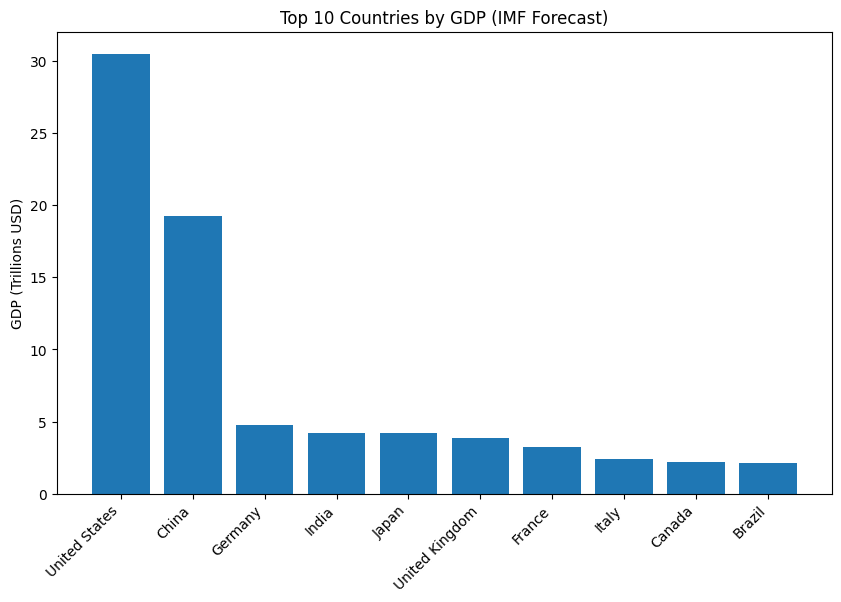

In [27]:
# Top 10 Countries by GDP

top10 = df.sort_values(by="IMF_Forecast", ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top10["Country"], top10["IMF_Forecast"]/1e6)  # divide by 1e6 → trillion scale
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Countries by GDP (IMF Forecast)")
plt.ylabel("GDP (Trillions USD)")
plt.show()

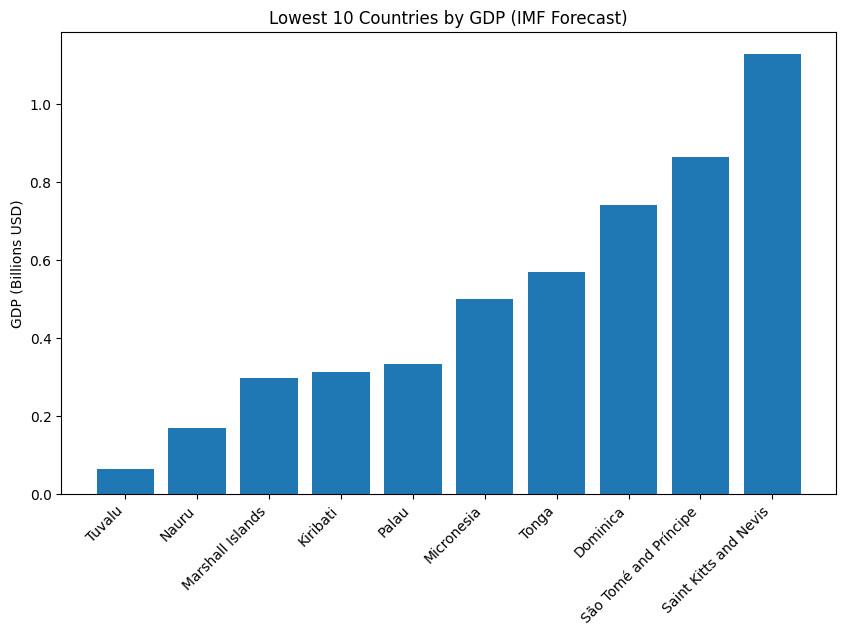

In [29]:
# Lowest 10 countries by GDP
lowest10 = df.sort_values(by="IMF_Forecast", ascending=True).head(10)

plt.figure(figsize=(10,6))
plt.bar(lowest10["Country"], lowest10["IMF_Forecast"]/1e3)  # divide by 1e3 → billion scale
plt.xticks(rotation=45, ha='right')
plt.title("Lowest 10 Countries by GDP (IMF Forecast)")
plt.ylabel("GDP (Billions USD)")
plt.show()

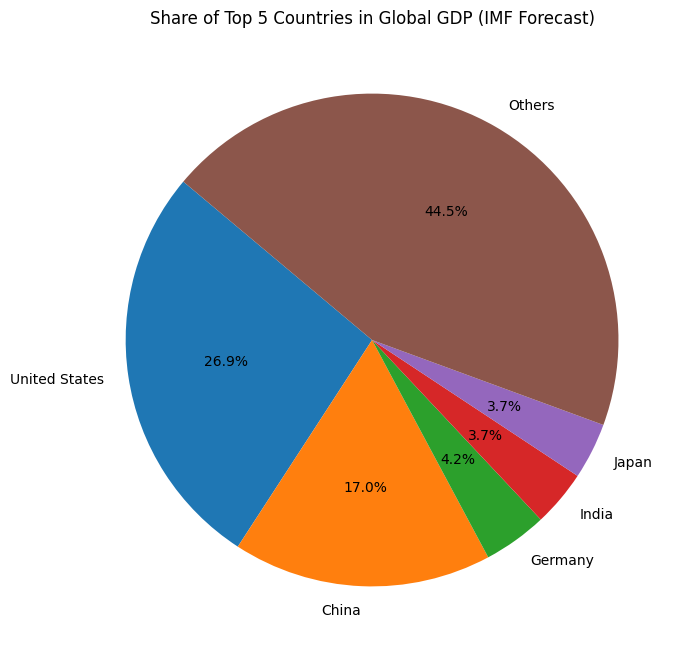

In [33]:
# Share of Top 5 Countries in World GDP

# Total GDP of all countries
total_gdp = df["IMF_Forecast"].sum()

# Top 5 countries
top5 = df.sort_values(by="IMF_Forecast", ascending=False).head(5)

# GDP of "Others"
others_gdp = total_gdp - top5["IMF_Forecast"].sum()

# Add "Others" row
labels = list(top5["Country"]) + ["Others"]
sizes = list(top5["IMF_Forecast"]) + [others_gdp]

# Pie chart
plt.figure(figsize=(8,8))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Share of Top 5 Countries in Global GDP (IMF Forecast)")
plt.show()
